In [77]:
#importing all necessary packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Data Decription

u.data: Contains 100,000 ratings by 943 users on 1,682 items (movies). Each record has:

* User ID
* Movie ID
* Rating (1-5)
* Timestamp

u.user: Contains demographic information about the users:

* User ID
* Age
* Gender
* Occupation
* Zip Code

u.item: Contains information about the movies:

* Movie ID
* Movie title
* Release date
* Video release date
* IMDb URL
* Genres (19 genres represented as binary values)

u.genre: List of movie genres.

u.occupation: List of different occupations.

ua.train and ua.test: Splits of the u.data file, used for training and testing. The test set contains 10 ratings per user.

## Looking into dataset

**1.1. Import the csv file and list the information about the features in the loaded dataset.**

In [78]:
u_data = pd.read_csv('data/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
u_data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [79]:
u_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


No missing data in this table

In [80]:
# Get summary statistics
u_data.describe()

,user_id,movie_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


Load and check other files

In [81]:
u_user = pd.read_csv('data/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
u_user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [82]:
# Check missing values
u_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


No missing values

In [83]:
# Load u.item, add headers
u_item = pd.read_csv('data/u.item', sep='|', encoding='latin-1', header=None, names=['movie_id',
                          'movie_title', 'release_date', 'video_release_date',
                          'imdb_url', 'unknown', 'action', 'adventure', 'animation', 'childrens',
                          'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film_noir',
                          'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])
u_item

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
u_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   imdb_url            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   action              1682 non-null   int64  
 7   adventure           1682 non-null   int64  
 8   animation           1682 non-null   int64  
 9   childrens           1682 non-null   int64  
 10  comedy              1682 non-null   int64  
 11  crime               1682 non-null   int64  
 12  documentary         1682 non-null   int64  
 13  drama               1682 non-null   int64  
 14  fantasy             1682 non-null   int64  
 15  film_noir           1682 non-null   int64  
 16  horror

Note that entire video_release_date column is missing, and the column release_date and imdb_url contain missing values.

In [85]:
# Load u.occupation
u_occupation = pd.read_csv('data/u.occupation', sep='|', header=None, names=['occupation'])
u_occupation

,occupation
0,administrator
1,artist
2,doctor
3,educator
4,engineer
5,entertainment
6,executive
7,healthcare
8,homemaker
9,lawyer


In [86]:
# Load u.genre
u_genre = pd.read_csv('data/u.genre', sep='|', header=None, names=['genre', 'code'])

# Get list of movie genre
genre_list = u_genre['genre'].values.tolist()
genre_list

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

## Data Cleaning and Preprocessing

Since the temporal aspect of u.data can be ignored, the timestamp column can be dropped. Name the resulting movie rating dataframe as "ratings".

In [87]:
ratings = u_data.drop('timestamp', axis=1)
ratings

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In u_item, video_release_date is missing, this feature is redundant since there is another release_date feature.

In [88]:
# Drop video_release_date in u_item, name the resulting dataframe as movies
movies = u_item.drop('video_release_date', axis=1)

In u_item, the column release_date and imdb_url contain missing values. Find out which rows containing missing values

In [89]:
# Show the rows with missing values in movies
movies[movies.isnull().any(axis=1)]

,movie_id,movie_title,release_date,imdb_url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
266,267,unknown,NaN,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1357,1358,The Deadly Cure (1996),16-Sep-1996,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1358,1359,Boys in Venice (1996),24-Sep-1996,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The row with missing release_date and missing imdb_url is having "unknown" as movie_title, it doesn't look like a proper entry. With only 1 row having missing value, dropping them will not affect downstream analysis.

In [90]:
# Drop missing values in u_item release_date column
movies = movies.dropna(subset=['release_date'])
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1681 entries, 0 to 1681
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie_id      1681 non-null   int64 
 1   movie_title   1681 non-null   object
 2   release_date  1681 non-null   object
 3   imdb_url      1679 non-null   object
 4   unknown       1681 non-null   int64 
 5   action        1681 non-null   int64 
 6   adventure     1681 non-null   int64 
 7   animation     1681 non-null   int64 
 8   childrens     1681 non-null   int64 
 9   comedy        1681 non-null   int64 
 10  crime         1681 non-null   int64 
 11  documentary   1681 non-null   int64 
 12  drama         1681 non-null   int64 
 13  fantasy       1681 non-null   int64 
 14  film_noir     1681 non-null   int64 
 15  horror        1681 non-null   int64 
 16  musical       1681 non-null   int64 
 17  mystery       1681 non-null   int64 
 18  romance       1681 non-null   int64 
 19  sci_fi     

For the other 2 entries with missing imdb_url, Google search shows that these 2 movies are less popular and their IMDB pages are indeed not available. As this imdb_url feature is not useful in analysis later, we don't need to handle missing values for now.

The release_date feature can be converted to release_year in number format, which could be useful in later stage to recommend movie from the same year.

In [91]:
# Convert release_date to release year (integer without decimal)
movies['release_date'] = pd.to_datetime(u_item['release_date'])
movies['release_date'] = movies['release_date'].dt.year.astype(int)

# Rename column
movies = movies.rename(columns={'release_date': 'release_year'})
movies

,movie_id,movie_title,release_year,imdb_url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),1998,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Look for duplicates in the movies data.

In [44]:
# Check duplicate in u_data
ratings[ratings.duplicated()]

,user_id,movie_id,rating


In [92]:
# Check duplicate in u_item
movies[movies.duplicated()]

,movie_id,movie_title,release_year,imdb_url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western


There is no duplicate entries in both data

Next, check whether all movie ids in data are included in movies

In [93]:
# check whether all movie ids in data are included in u_item
ratings['movie_id'].isin(movies['movie_id']).value_counts()

,count
movie_id,
True,99991
False,9


In [94]:
# Show which item_id are not in u_item
ratings[~ratings['movie_id'].isin(movies['movie_id'])]

,user_id,movie_id,rating
2172,130,267,5
3781,5,267,4
7245,268,267,3
12475,297,267,3
14756,319,267,4
15292,1,267,4
49295,532,267,3
93523,833,267,1
99723,422,267,4


Item_id 267 is the move with 'unknown' title, which was dropped earlier. Since this item is not in movies list, we can update the ratings dataframe based on movies present in movies.

In [95]:
print(ratings.shape)
available_movie_id = movies['movie_id'].unique()
ratings = ratings[ratings.movie_id.isin(available_movie_id)]
print(ratings.shape)

(100000, 3)
(99991, 3)


## Exploratory Data Analysis

Plot histogram of ratings.

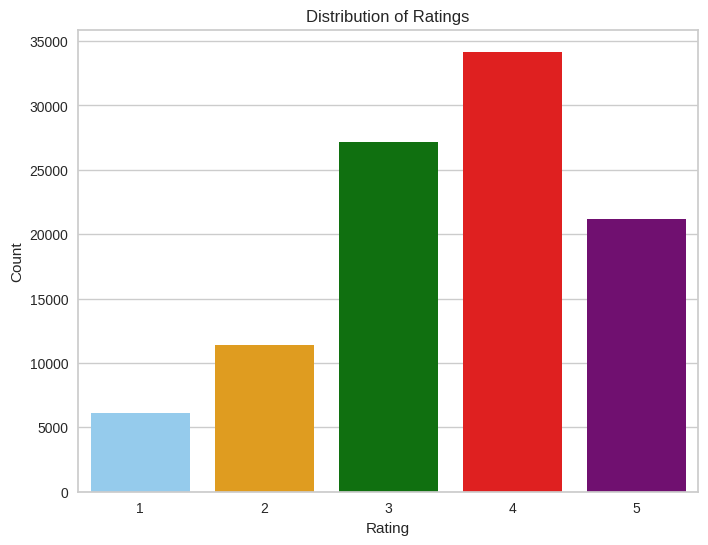

In [ ]:
# Distribution of Ratings
my_palette = ["#87cefa", "#ffa500", "#008000", "#ff0000", "#800080"]
plt.figure(figsize=(8, 6))
# sns.countplot(data=ratings, x='rating')
sns.countplot(data=ratings, x='rating', palette=my_palette)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Plot the histogram of ratings across users.

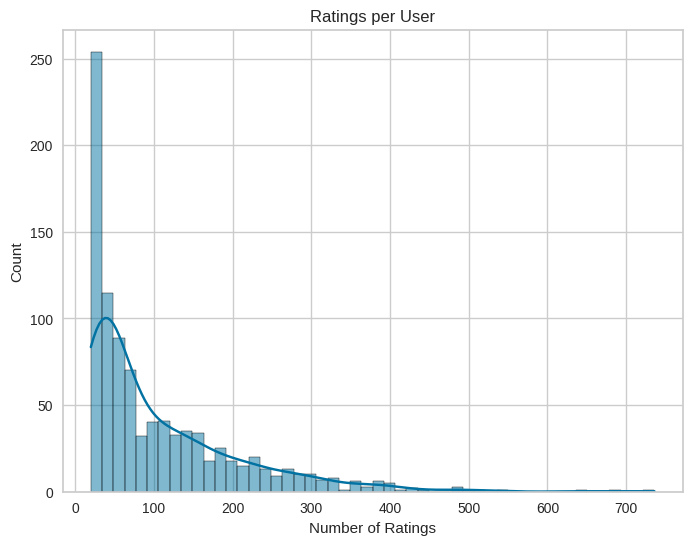

In [ ]:
# Ratings per User
user_ratings_count = ratings.groupby('user_id')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(user_ratings_count, bins=50, kde=True)
plt.title('Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

Long-tail distribution, most user have < 300 ratings.

Plot the histogram of ratings across movies

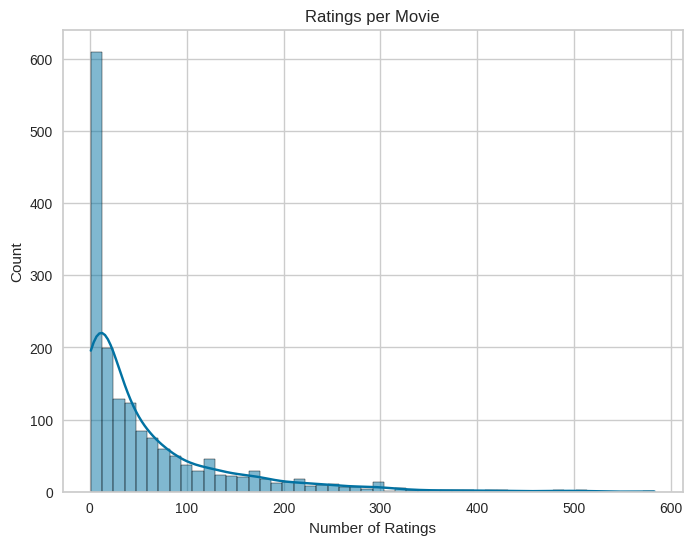

In [96]:
# Ratings per movie
movie_ratings_count = ratings.groupby('movie_id')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(movie_ratings_count, bins=50, kde=True)
plt.title('Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

This seems to be a long-tail distribution, some movies have 0 or only a few ratings.

Next, we can plot average rating vs. number of ratings. Before that, we need to create these 2 features in movies dataframe.

In [97]:
# In movies, create ratings_count column, total rating count for each movie
ratings_count = ratings.groupby('movie_id')['rating'].count()
movies['ratings_count'] = movies['movie_id'].map(ratings_count)
movies['ratings_count']


,ratings_count
0,452
1,131
2,90
3,209
4,86
...,...
1677,1
1678,1
1679,1
1680,1


In [99]:
# Create average rating
average_rating = ratings.groupby('movie_id')['rating'].mean()
movies['average_rating'] = movies['movie_id'].map(average_rating)
movies['average_rating']

,average_rating
0,3.878319
1,3.206107
2,3.033333
3,3.550239
4,3.302326
...,...
1677,1.000000
1678,3.000000
1679,2.000000
1680,3.000000


Plot average rating and number of ratings.

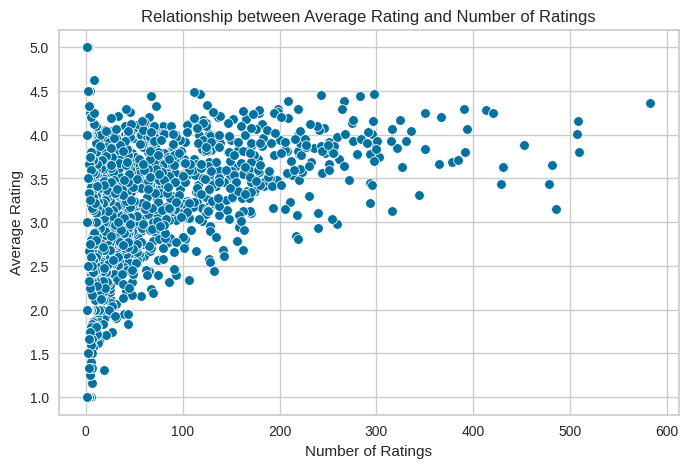

In [100]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='ratings_count', y='average_rating', data=movies)
plt.title('Relationship between Average Rating and Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

Again, most movies rae having < 100 ratings. Majority of average rating is the range between 2.0 and 4.0.

Next, let's find out the top 10 most popular movies

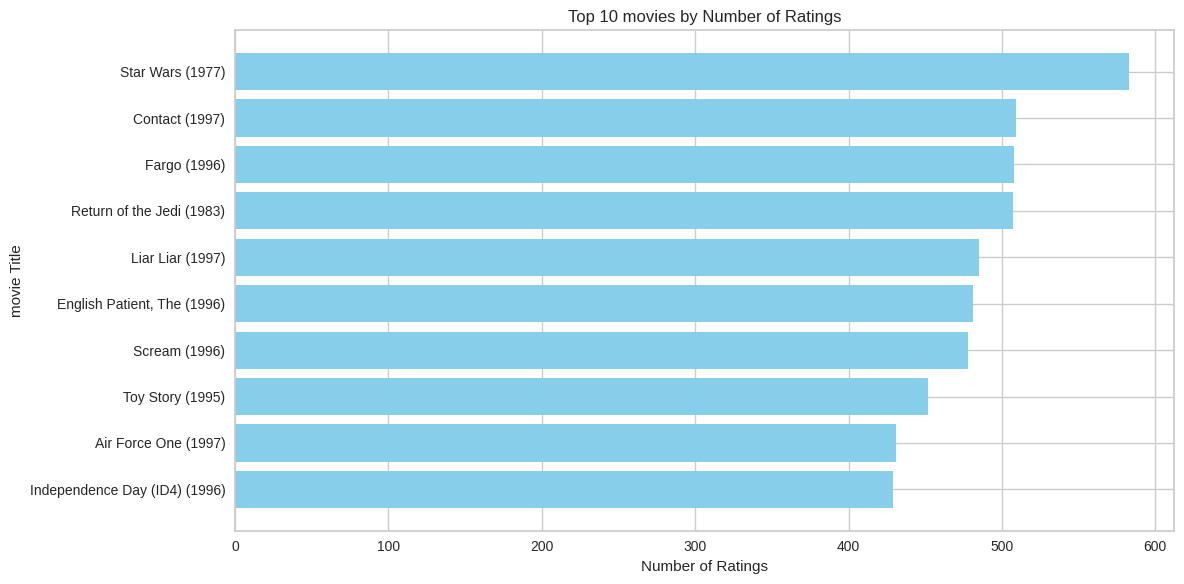

In [102]:
# Calculate the number of ratings for each movie
movie_ratings_count = ratings['movie_id'].value_counts().reset_index()
movie_ratings_count.columns = ['movie_id', 'ratings_count']

# Sort the movies based on the number of ratings in descending order
movie_ratings_count = movie_ratings_count.sort_values(by='ratings_count', ascending=False)

# Define the number of top-rated movies to plot
num_top_movies_to_plot = 10

# Select the top N movies
top_movies = movie_ratings_count.head(num_top_movies_to_plot)

# Get movie titles for the top-rated movies
top_movies_titles = [movies[movies['movie_id'] == movie_id]['movie_title'].values[0] for movie_id in top_movies['movie_id']]

# Create a bar plot to visualize the number of ratings for the top-rated movies
plt.figure(figsize=(12, 6))
plt.barh(top_movies_titles, top_movies['ratings_count'], color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.title(f'Top {num_top_movies_to_plot} Movies by Number of Ratings')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest-rated movie at the top
plt.tight_layout()
plt.show()